# DonorsChoose.org Application Screening
### Predict whether teachers' project proposals are accepted or not

## 1.0 Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import gc


from IPython.display import display
pd.options.display.max_columns = None


#plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

color = sns.color_palette()
import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode()
import plotly.tools as tls

# Supress unnecessary warnings so that presentation looks clean
import warnings
warnings.filterwarnings("ignore")


#Text processing libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

from nltk import word_tokenize
from nltk.corpus import stopwords
#from textblob import TextBlob
import string


stop_words = list(set(stopwords.words('english')))
warnings.filterwarnings('ignore')
punctuation = string.punctuation


#date time processing libraries
import datetime as dt
import string
import time
import datetime

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


## 2.0 Import Data

In [4]:
# Read data and store in DataFrame.
train_data = pd.read_csv('train.csv', sep=',', date_parser="project_submitted_datetime")
resources_data = pd.read_csv('resources.csv', sep=',')
test_data = pd.read_csv('test.csv')
target_data = train_data['project_is_approved']

In [5]:
#Remove target data from train dataset so it has same dimensions as test set
train_data.drop("project_is_approved",inplace=True,axis=1)

In [6]:
print("Size of training data : ",train_data.shape)
print("Size of test data : ",test_data.shape)
print("Size of resource data : ",resources_data.shape)
print("Size of target data: ",target_data.shape )

Size of training data :  (182080, 15)
Size of test data :  (78035, 15)
Size of resource data :  (1541272, 4)
Size of target data:  (182080,)


## 3.0 View the Data

### 3.1 Overview of the tables

##### Training Data  





In [7]:
train_data.head(3)

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects
0,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...,26
1,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1
2,p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,NaN,My students need the 3doodler. We are an SEM s...,5


##### Test Data

In [8]:
test_data.head(3)

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects
0,p233245,5724a0c3ce11008366fff36dab4b943c,Ms.,CA,2016-04-27 13:45:41,Grades PreK-2,Music & The Arts,Visual Arts,Art Will Make You Happy!,My 2nd grade students are amazing! They are v...,My class is made up of 12 boys and 12 girls. ...,My second grade class will really benefit from...,The genorous donations to my project will make...,My students need a drying rack for their art p...,2
1,p096795,445619941dc7cbe81c7be109dc61a56a,Mrs.,SC,2016-04-28 12:43:56,Grades 3-5,"Literacy & Language, Math & Science","Literature & Writing, Mathematics",Keeping up with the TIMEs,Students within the classroom work in small gr...,My students are all very talented young indivi...,"We do a lot of small group, where the student ...",This project is very important to my classroom...,My students need Time Magazines for next year ...,1
2,p236235,e92a4902b1611a189643d6f12c51e6a0,Mrs.,SC,2016-04-29 21:16:05,Grades PreK-2,Math & Science,"Applied Sciences, Mathematics",Building Bridges to Problem Solving,My students share a love of learning. These s...,My class consists of 14 energetic learners. O...,These Fairy Tale Problem Solving STEM kits wil...,These materials will be help my students with ...,My students need to be mentally stimulated to ...,0


##### Resources Data

In [9]:
resources_data.head(10)

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45
3,p069063,"Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...",2,13.59
4,p069063,EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...,3,24.95
5,p069063,Last to Finish: A Story About the Smartest Boy...,1,16.99
6,p069063,"Mrs. Gorski, I Think I Have the Wiggle Fidgets...",1,9.95
7,p069063,"See-N-Read 1503905CQ Reading Tool - Book Size,...",2,10.11
8,p096795,"Brewster WPD90218 Wall Pops Flirt Dot, Set of ...",2,9.95
9,p096795,Brewster Wall Pops WPE99065 Peel & Stick Calyp...,2,9.02


### 3.2 Statisical Overview of the Data

**Desription of the training data.**

In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182080 entries, 0 to 182079
Data columns (total 15 columns):
id                                              182080 non-null object
teacher_id                                      182080 non-null object
teacher_prefix                                  182076 non-null object
school_state                                    182080 non-null object
project_submitted_datetime                      182080 non-null object
project_grade_category                          182080 non-null object
project_subject_categories                      182080 non-null object
project_subject_subcategories                   182080 non-null object
project_title                                   182080 non-null object
project_essay_1                                 182080 non-null object
project_essay_2                                 182080 non-null object
project_essay_3                                 6374 non-null object
project_essay_4                        

**Desription of the training data numerical features.**

In [11]:
train_data.describe()

,teacher_number_of_previously_posted_projects
count,182080.000000
mean,11.237055
std,28.016086
min,0.000000
25%,0.000000
50%,2.000000
75%,9.000000
max,451.000000


**Desription of the training data categorical features.**

In [12]:
train_data.describe(include=["O"])

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary
count,182080,182080,182076,182080,182080,182080,182080,182080,182080,182080,182080,6374,6374,182080
unique,182080,104414,5,51,180439,4,51,407,164282,147689,180984,6359,6336,179730
top,p229568,fa2f220b537e8653fb48878ebb38044d,Mrs.,CA,2016-09-01 00:00:03,Grades PreK-2,Literacy & Language,Literacy,Flexible Seating,As a teacher in a low-income/high poverty scho...,Students will be using Chromebooks to increase...,"Daily, students will check out their chrome bo...","As a teacher, it is important to show students...",My students need electronic tablets to do all ...
freq,1,74,95405,25695,30,73890,39257,15775,377,46,24,2,3,84


In [13]:
resources_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1541272 entries, 0 to 1541271
Data columns (total 4 columns):
id             1541272 non-null object
description    1540980 non-null object
quantity       1541272 non-null int64
price          1541272 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 47.0+ MB


In [14]:
resources_data.describe()

,quantity,price
count,1.541272e+06,1.541272e+06
mean,2.860509e+00,5.028398e+01
std,7.570345e+00,1.447326e+02
min,1.000000e+00,0.000000e+00
25%,1.000000e+00,7.900000e+00
50%,1.000000e+00,1.499000e+01
75%,2.000000e+00,3.980000e+01
max,8.000000e+02,9.999000e+03


In [15]:
resources_data.describe(include=["O"])

,id,description
count,1541272,1540980
unique,260115,332928
top,p066966,Apple - iPad� mini 2 with Wi-Fi - 16GB - Space...
freq,100,3037


## 4.0 Data Preperation

### 4.1 Checking for missing data

**Missing Data in train_data**

In [16]:
# checking missing data in training data 
total = train_data.isnull().sum().sort_values(ascending = False)
percent = (train_data.isnull().sum()/train_data.isnull().count()*100).sort_values(ascending = False)
missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train_data.head()

,Total,Percent
project_essay_4,175706,96.499341
project_essay_3,175706,96.499341
teacher_prefix,4,0.002197
teacher_number_of_previously_posted_projects,0,0.000000
project_resource_summary,0,0.000000


* 96% of data rows are empty for project_essay_4 and project_essay_3 so I will remove these two columns beforing fitting prediction models.

**Missing Data in Test Data**

In [17]:
# checking missing data in training data 
total = test_data.isnull().sum().sort_values(ascending = False)
percent = (test_data.isnull().sum()/test_data.isnull().count()*100).sort_values(ascending = False)
missing_test_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_test_data.head()

,Total,Percent
project_essay_4,75331,96.534888
project_essay_3,75331,96.534888
teacher_prefix,1,0.001281
teacher_number_of_previously_posted_projects,0,0.000000
project_resource_summary,0,0.000000


* In test data 96% of data rows are empty for project_essay_4 and project_essay_3 so I will remove these two columns beforing fitting prediction models.

**Missing data in resources_data**

In [18]:
# checking missing data in resource data

total = resources_data.isnull().sum().sort_values(ascending = False)
percent = (resources_data.isnull().sum()/resources_data.isnull().count()*100).sort_values(ascending = False)
missing_resources_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_resources_data.head()

,Total,Percent
description,292,0.018945
price,0,0.000000
quantity,0,0.000000
id,0,0.000000


* In the resources csv there are only a few missing descriptions. These are small enough that we can ignore these null values in our analysis (0.01894%)

**Remove Columns for Essay 3 and 4**

In [19]:
#Remove unwanted columns
columns_to_remove = ["project_essay_3","project_essay_4"]
train_data.drop(columns_to_remove,inplace=True,axis=1)
test_data.drop(columns_to_remove,inplace=True,axis=1)

train_data.shape

(182080, 13)

In [20]:
test_data.shape

(78035, 13)

## 5.0 Data Exploration

### 5.1 Project is approved or not

Total number of rows is: 182080
Total number of approved applications is : 154346
Total percentage of approved applications is : 84.8%
Total percentage of applications not approved is : 15.2%


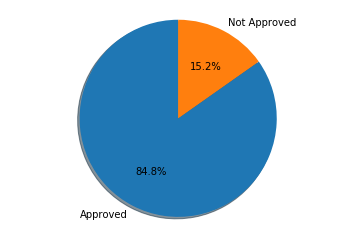

In [21]:
number_rows = target_data.count()
print ("Total number of rows is: {}".format(number_rows))

total_approved= target_data.sum()
print ("Total number of approved applications is : {}".format(total_approved))

percentage_approved = float(total_approved/number_rows)*100
print ("Total percentage of approved applications is : {0:.1f}%".format(percentage_approved))

percentage_not_approved = 100 - percentage_approved
print ("Total percentage of applications not approved is : {0:.1f}%".format(percentage_not_approved))

#Create pie-chart representation
labels = 'Approved', 'Not Approved'
fractions = [percentage_approved, percentage_not_approved]

fig1, ax1 = plt.subplots()
ax1.pie(fractions, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


* The data appears to be highly imbalanced with 85% of applications being approved versus only 15% that are not approved.

### 5.2 Influence of state on % approved

In [22]:
temp = train_data["school_state"].value_counts()
#print(temp.values)
temp_y0 = []
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(target_data[train_data["school_state"]==val] == 1))
    temp_y0.append(np.sum(target_data[train_data["school_state"]==val] == 0))    
trace1 = go.Bar(
    x = temp.index,
    y = temp_y1,
    name='Accepted Proposals'
)
trace2 = go.Bar(
    x = temp.index,
    y = temp_y0, 
    name='Rejected Proposals'
)

data = [trace1, trace2]
layout = go.Layout(
    title = "Popular School states in terms of project acceptance rate and project rejection rate",
    barmode='stack',
    width = 1000
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)


### 5.3 Influence of Teacher Prefix on % approved

In [23]:
temp = train_data["teacher_prefix"].value_counts()
temp_y0 = []
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(target_data[train_data["teacher_prefix"]==val] == 1))
    temp_y0.append(np.sum(target_data[train_data["teacher_prefix"]==val] == 0))    
trace1 = go.Bar(
    x = temp.index,
    y = temp_y1,
    name='Accepted Proposals'
)
trace2 = go.Bar(
    x = temp.index,
    y = temp_y0, 
    name='Rejected Proposals'
)

data = [trace1, trace2]
layout = go.Layout(
    title = "Popular Teacher prefixes in terms of project acceptance rate and project rejection rate",
    barmode='stack',
    width = 1000
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

### 5.4 Influence of School Grade on % approved

In [24]:
temp = train_data["project_grade_category"].value_counts()
#print(temp.values)
temp_y0 = []
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(target_data[train_data["project_grade_category"]==val] == 1))
    temp_y0.append(np.sum(target_data[train_data["project_grade_category"]==val] == 0))    
trace1 = go.Bar(
    x = temp.index,
    y = temp_y1,
    name='Accepted Proposals'
)
trace2 = go.Bar(
    x = temp.index,
    y = temp_y0, 
    name='Rejected Proposals'
)

data = [trace1, trace2]
layout = go.Layout(
    title = "Popular school grade levels in terms of project acceptance rate and project rejection rate",
    barmode='stack',
    width = 1000
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

### 5.5 Influence of Project Category on Acceptance Rate

In [25]:
temp = train_data["project_subject_categories"].value_counts()
#print(temp.values)
temp_y0 = []
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(target_data[train_data["project_subject_categories"]==val] == 1))
    temp_y0.append(np.sum(target_data[train_data["project_subject_categories"]==val] == 0))    
trace1 = go.Bar(
    x = temp.index,
    y = temp_y1,
    name='Accepted Proposals'
)
trace2 = go.Bar(
    x = temp.index,
    y = temp_y0, 
    name='Rejected Proposals'
)

data = [trace1, trace2]
layout = go.Layout(
    title = "Popular category of the project in terms of project acceptance rate and project rejection rate",
    barmode='stack',
    width = 1000
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

### 5.6 Influence of Project Sub-Category on Acceptance Rate

In [26]:
temp = train_data["project_subject_subcategories"].value_counts()
#print(temp.values)
temp_y0 = []
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(target_data[train_data["project_subject_subcategories"]==val] == 1))
    temp_y0.append(np.sum(target_data[train_data["project_subject_subcategories"]==val] == 0))    
trace1 = go.Bar(
    x = temp.index,
    y = temp_y1,
    name='Accepted Proposals'
)
trace2 = go.Bar(
    x = temp.index,
    y = temp_y0, 
    name='Rejected Proposals'
)

data = [trace1, trace2]
layout = go.Layout(
    title = "Popular subcategory of the project in terms of project acceptance rate and project rejection rate",
    barmode='stack',
    width = 1000
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

### 5.6 Influence of Project Title on Acceptance Rate

In [27]:
temp = train_data["project_title"].value_counts().head(20)
#print(temp.values)
temp_y0 = []
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(target_data[train_data["project_title"]==val] == 1))
    temp_y0.append(np.sum(target_data[train_data["project_title"]==val] == 0))    
trace1 = go.Bar(
    x = temp.index,
    y = temp_y1,
    name='Accepted Proposals'
)
trace2 = go.Bar(
    x = temp.index,
    y = temp_y0, 
    name='Rejected Proposals'
)

data = [trace1, trace2]
layout = go.Layout(
    title = "Popular project titles in terms of project acceptance rate and project rejection rate",
    barmode='stack',
    width = 1000
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

### 5.7 Influence of Number of Project Submissions on Acceptance Rate

In [28]:
temp = train_data["teacher_number_of_previously_posted_projects"].value_counts().head(50)
#print(temp.values)
temp_y0 = []
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(target_data[train_data["teacher_number_of_previously_posted_projects"]==val] == 1))
    temp_y0.append(np.sum(target_data[train_data["teacher_number_of_previously_posted_projects"]==val] == 0))    
trace1 = go.Bar(
    x = temp.index,
    y = temp_y1,
    name='Accepted Proposals'
)
trace2 = go.Bar(
    x = temp.index,
    y = temp_y0, 
    name='Rejected Proposals'
)

data = [trace1, trace2]
layout = go.Layout(
    title = "Influence of Number of Previous Project Submissions on Acceptance Rate",
    barmode='stack',
    width = 1000
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## 6.0 Feature Engineering


#### 6.1 Aggregated Features

Features obtained by aggregating the fields from resources data and the training data

* **Feature 1,2,3** - Min Price, Max Price, Mean Price: Min, Max, and Mean value of Price of resources requested.

* **Feature 4,5,6** - Min Quantity, Max Quantity, Mean Quantity: Min, Max, and Mean value of Quantity of resources requested.

* **Feature 7,8,9** - Min Total Price, Max Total Price, Mean Total Price: Min, Max, and Mean value of Total Price of resources requested.

* **Feature 10,11,12** - Sum of Total Price: Total price of all the resoruces requested by the teacher in a proposal

* **Feature 13** - Items Requested: Total unique number of items requested by the teacher in a proposal

* **Feature 14** - Quantity: Total number of quantities requested by the teacher in a proposal

In [29]:
resources_data['total_price'] = resources_data['quantity']*resources_data['price']

agg_rc = resources_data.groupby('id').agg({'description':'count', 'quantity':'sum', 'price':'sum', 'total_price':'sum'}).rename(columns={'description':'items'})

agg_rc.head(10)

for func in ['min', 'max', 'mean']:
    agg_rc_temp = resources_data.groupby('id').agg({'quantity':func, 'price':func, 'total_price':func}).rename(columns={'quantity':func+'_quantity', 'price':func+'_price', 'total_price':func+'_total_price'}).fillna(0)
    agg_rc = agg_rc.join(agg_rc_temp)
    

agg_rc = agg_rc.join(resources_data.groupby('id').agg({'description':lambda x:' '.join(x.values.astype(str))}).rename(columns={'description':'resource_description'}))
    
train_data = train_data.join(agg_rc, on='id')
display(train_data.head(3))
train_data.shape


,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_resource_summary,teacher_number_of_previously_posted_projects,items,quantity,price,total_price,min_quantity,min_price,min_total_price,max_quantity,max_price,max_total_price,mean_quantity,mean_price,mean_total_price,resource_description
0,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,My students need 6 Ipod Nano's to create and d...,26,2,6,299.98,899.94,3,149.99,449.97,3,149.99,449.97,3.0,149.99,449.97,Apple - iPod nano� 16GB MP3 Player (8th Genera...
1,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,My students need matching shirts to wear for d...,1,1,20,20.00,400.00,20,20.00,400.00,20,20.00,400.00,20.0,20.00,400.00,Reebok Girls' Fashion Dance Graphic T-Shirt - ...
2,p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,My students need the 3doodler. We are an SEM s...,5,1,1,469.99,469.99,1,469.99,469.99,1,469.99,469.99,1.0,469.99,469.99,3doodler Start Full Edu Bundle


(182080, 27)

In [30]:
test_data = test_data.join(agg_rc, on='id')
display(test_data.head(3))
test_data.shape

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_resource_summary,teacher_number_of_previously_posted_projects,items,quantity,price,total_price,min_quantity,min_price,min_total_price,max_quantity,max_price,max_total_price,mean_quantity,mean_price,mean_total_price,resource_description
0,p233245,5724a0c3ce11008366fff36dab4b943c,Ms.,CA,2016-04-27 13:45:41,Grades PreK-2,Music & The Arts,Visual Arts,Art Will Make You Happy!,My 2nd grade students are amazing! They are v...,My class is made up of 12 boys and 12 girls. ...,My students need a drying rack for their art p...,2,1,1,149.00,149.00,1,149.00,149.00,1,149.00,149.0,1.000000,149.000000,149.000000,LC652 - Lakeshore Double-Space Mobile Drying Rack
1,p096795,445619941dc7cbe81c7be109dc61a56a,Mrs.,SC,2016-04-28 12:43:56,Grades 3-5,"Literacy & Language, Math & Science","Literature & Writing, Mathematics",Keeping up with the TIMEs,Students within the classroom work in small gr...,My students are all very talented young indivi...,My students need Time Magazines for next year ...,1,3,44,23.98,238.34,2,5.01,18.04,40,9.95,200.4,14.666667,7.993333,79.446667,"Brewster WPD90218 Wall Pops Flirt Dot, Set of ..."
2,p236235,e92a4902b1611a189643d6f12c51e6a0,Mrs.,SC,2016-04-29 21:16:05,Grades PreK-2,Math & Science,"Applied Sciences, Mathematics",Building Bridges to Problem Solving,My students share a love of learning. These s...,My class consists of 14 energetic learners. O...,My students need to be mentally stimulated to ...,0,1,2,149.00,298.00,2,149.00,298.00,2,149.00,298.0,2.000000,149.000000,298.000000,PP440X - Fairy Tales Problem Solving STEM Kits


(78035, 27)

#### 6.2 Date-Time Features

Features obtained by aggregating the fields from resources data and the training data

Features extracted from project submitted datetime

* **Feature 15** - Year of Submission: Value of year when the proposal was submitted
* **Feature 16** - Month of Submission: Month number (values between 1 to 12) when the proposal was submitted
* **Feature 17** - Week Day of Submission: Week Day value (values between 1 to 7) when the proposal was submitted
* **Feature 18** - Hour of Submission: Value of time hour (values between 0 to 23) when the proposal was submitted
* **Feature 19** - Year Day of Submission: Year Day (values between 1 to 365) when the proposal was submitted
* **Feature 20** - Month Day of Submission: Month Day (values between 1 to 31) when the proposal was submitted

In [31]:
train_data["project_submitted_datetime"] = pd.to_datetime(train_data['project_submitted_datetime'])
test_data["project_submitted_datetime"] = pd.to_datetime(test_data['project_submitted_datetime'])

# extracting datetime features using datetime module (Train Data)
train_data["Year"] = train_data["project_submitted_datetime"].dt.year
train_data["Month"] = train_data["project_submitted_datetime"].dt.month
train_data['Weekday'] = train_data['project_submitted_datetime'].dt.weekday
train_data["Hour"] = train_data["project_submitted_datetime"].dt.hour
train_data["Month_Day"] = train_data['project_submitted_datetime'].dt.day
train_data["Year_Day"] = train_data['project_submitted_datetime'].dt.dayofyear

train_data.shape

(182080, 33)

In [32]:
# extracting datetime features using datetime module (Test Data)
test_data["Year"] = test_data["project_submitted_datetime"].dt.year
test_data["Month"] = test_data["project_submitted_datetime"].dt.month
test_data['Weekday'] = test_data['project_submitted_datetime'].dt.weekday
test_data["Hour"] = test_data["project_submitted_datetime"].dt.hour
test_data["Month_Day"] = test_data['project_submitted_datetime'].dt.day
test_data["Year_Day"] = test_data['project_submitted_datetime'].dt.dayofyear

test_data.shape

(78035, 33)

In [33]:
train_data[['Year', 'Month', 'Weekday', 'Hour', 'Month_Day', 'Year_Day']].head(3)


,Year,Month,Weekday,Hour,Month_Day,Year_Day
0,2016,11,4,14,18,323
1,2017,4,2,15,26,116
2,2017,1,6,22,1,1


In [34]:
test_data[['Year', 'Month', 'Weekday', 'Hour', 'Month_Day', 'Year_Day']].head(3)

,Year,Month,Weekday,Hour,Month_Day,Year_Day
0,2016,4,2,13,27,118
1,2016,4,3,12,28,119
2,2016,4,4,21,29,120


#### 6.3 Text Based Features

Features extracted from proposal essay text and resources description

* **Feature 21:** Length of Essay 1 - total number of characters in essay 1 including spaces
* **Feature 22:** Length of Essay 2 - total number of characters in essay 2 including spaces
* **Feature 23:** Length of Project Title - total number of characters in project title including spaces
* **Feature 24:** Word Count in the Complete Essay - total number of words in the complete essay text
* **Feature 25:** Character Count in the Complete Essay - total number of characters in complete essay text
* **Feature 26:** Word Density of the Complete Essay - average length of the words used in the essay
* **Feature 27:** Puncutation Count in the Complete Essay - total number of punctuation marks in the essay
* **Feature 28:** Upper Case Count in the Complete Essay - total number of upper count words in the essay
* **Feature 29:** Title Word Count in the Complete Essay - total number of proper case (title) words in the essay
* **Feature 30:** Stopword Count in the Complete Essay - total number of stopwords in the essay

In [35]:
# extract length of each essay and title (Train Data)
train_data["essay1_len"] = train_data['project_essay_1'].apply(len)
train_data["essay2_len"] = train_data['project_essay_2'].apply(len)
train_data["title_len"] = train_data['project_title'].apply(len)

train_data.shape

(182080, 36)

In [36]:
# extract length of each essay and title (Test Data)
test_data["essay1_len"] = test_data['project_essay_1'].apply(len)
test_data["essay2_len"] = test_data['project_essay_2'].apply(len)
test_data["title_len"] = test_data['project_title'].apply(len)

test_data.shape

(78035, 36)

In [37]:
train_data[['essay1_len', 'essay2_len', 'title_len']].head(3)

,essay1_len,essay2_len,title_len
0,967,805,24
1,587,639,22
2,761,546,21


In [38]:
test_data[['essay1_len', 'essay2_len', 'title_len']].head(3)

,essay1_len,essay2_len,title_len
0,249,299,24
1,292,514,25
2,119,324,35


In [39]:
# combine the project essays to create a complete essay text
train_data['text'] = train_data.apply(lambda row: ' '.join([str(row['project_essay_1']), 
                                            str(row['project_essay_2'])]), axis=1)

test_data['text'] = test_data.apply(lambda row: ' '.join([str(row['project_essay_1']), 
                                            str(row['project_essay_2'])]), axis=1)

# extract features from text (Train Data)
train_data['char_count'] = train_data['text'].apply(len)
train_data['word_count'] = train_data['text'].apply(lambda x: len(x.split()))
train_data['word_density'] = train_data['char_count'] / (train_data['word_count']+1)
train_data['punctuation_count'] = train_data['text'].apply(lambda x: len("".join(_ for _ in x if _ in punctuation))) 
train_data['title_word_count'] = train_data['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
train_data['upper_case_word_count'] = train_data['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
train_data['stopword_count'] = train_data['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.lower() in stop_words]))


# extract features from text (Text Data)
test_data['char_count'] = test_data['text'].apply(len)
test_data['word_count'] = test_data['text'].apply(lambda x: len(x.split()))
test_data['word_density'] = test_data['char_count'] / (test_data['word_count']+1)
test_data['punctuation_count'] = test_data['text'].apply(lambda x: len("".join(_ for _ in x if _ in punctuation))) 
test_data['title_word_count'] = test_data['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
test_data['upper_case_word_count'] = test_data['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
test_data['stopword_count'] = test_data['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.lower() in stop_words]))

In [40]:
train_data[['char_count', 'word_count', 'word_density', 'punctuation_count', 'title_word_count', 'upper_case_word_count', 'stopword_count']].head(3)
train_data.shape

(182080, 44)

In [41]:
test_data[['char_count', 'word_count', 'word_density', 'punctuation_count', 'title_word_count', 'upper_case_word_count', 'stopword_count']].head(3)
test_data.shape

(78035, 44)

#### 6.4 Remove unneeded Features

In [42]:
#Remove unwanted columns
columns_to_remove = ["teacher_id","project_submitted_datetime","text"]
train_data.drop(columns_to_remove,inplace=True,axis=1)
test_data.drop(columns_to_remove,inplace=True,axis=1)

train_data.shape

(182080, 41)

In [43]:
test_data.shape

(78035, 41)

## 7.0 Feature Scaleing and Transformation

#### 6.5 Split data into Numerical, Categorical & Text Types

In [44]:
categorical_columns = ["teacher_prefix", "school_state", "project_grade_category", "project_subject_categories",
                       "project_subject_subcategories", "Year", "Month", "Weekday", "Hour", "Month_Day", "Year_Day"]

numerical_columns = ["teacher_number_of_previously_posted_projects","quantity","price",
                    "items", "quantity", "price", "total_price", "min_quantity", "min_price",
                     "min_total_price","max_quantity","max_price","max_total_price",
                     "mean_quantity","mean_price","mean_total_price","essay1_len",
                     "essay2_len", "title_len", "char_count",
                     "word_count", "word_density", "punctuation_count", "title_word_count", 
                     "upper_case_word_count", "stopword_count"]

text_columns = ["project_essay_1","project_essay_2", "project_resource_summary", "resource_description", "project_title"]

In [45]:
train_data_categorical = train_data[categorical_columns]
train_data_numerical = train_data[numerical_columns]
train_data_text = train_data[text_columns]

test_data_categorical = test_data[categorical_columns]
test_data_numerical = test_data[numerical_columns]
test_data_text = test_data[text_columns]

display(train_data_categorical.shape)
display(train_data_numerical.shape)
display(train_data_text.shape)
display(test_data_categorical.shape)
display(test_data_numerical.shape)
display(test_data_text.shape)

(182080, 11)

(182080, 26)

(182080, 5)

(78035, 11)

(78035, 26)

(78035, 5)

In [46]:
train_data_numerical.head(3)

,teacher_number_of_previously_posted_projects,quantity,price,items,quantity,price,total_price,min_quantity,min_price,min_total_price,max_quantity,max_price,max_total_price,mean_quantity,mean_price,mean_total_price,essay1_len,essay2_len,title_len,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,stopword_count
0,26,6,299.98,2,6,299.98,899.94,3,149.99,449.97,3,149.99,449.97,3.0,149.99,449.97,967,805,24,1773,312,5.664537,40,21,5,151
1,1,20,20.00,1,20,20.00,400.00,20,20.00,400.00,20,20.00,400.00,20.0,20.00,400.00,587,639,22,1227,190,6.424084,38,15,3,79
2,5,1,469.99,1,1,469.99,469.99,1,469.99,469.99,1,469.99,469.99,1.0,469.99,469.99,761,546,21,1308,234,5.565957,26,26,4,103


In [47]:
train_data_text.head(3)

,project_essay_1,project_essay_2,project_resource_summary,resource_description,project_title
0,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,My students need 6 Ipod Nano's to create and d...,Apple - iPod nano� 16GB MP3 Player (8th Genera...,Super Sight Word Centers
1,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,My students need matching shirts to wear for d...,Reebok Girls' Fashion Dance Graphic T-Shirt - ...,Keep Calm and Dance On
2,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,My students need the 3doodler. We are an SEM s...,3doodler Start Full Edu Bundle,Lets 3Doodle to Learn


#### 6.6 Scale numerical features

In [48]:
from sklearn.preprocessing import StandardScaler

In [49]:
std = StandardScaler()

train_data_numerical_scaled = pd.DataFrame(std.fit_transform(train_data_numerical),columns=train_data_numerical.columns)
test_data_numerical_scaled = pd.DataFrame(std.fit_transform(test_data_numerical),columns=test_data_numerical.columns)

display(train_data_numerical_scaled.head(3))
display(train_data_numerical_scaled.shape)
display(test_data_numerical_scaled.head(3))
display(test_data_numerical_scaled.shape)

,teacher_number_of_previously_posted_projects,quantity,price,items,quantity,price,total_price,min_quantity,min_price,min_total_price,max_quantity,max_price,max_total_price,mean_quantity,mean_price,mean_total_price,essay1_len,essay2_len,title_len,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,stopword_count
0,0.526947,-0.418089,0.006132,-0.472000,-0.418089,0.006132,0.646102,-0.095428,0.217603,0.596712,-0.291728,-0.092457,0.201910,-0.184802,0.100378,0.453781,1.427952,-0.098231,-0.630058,0.660671,0.899505,-0.890997,0.098517,0.392207,0.433942,1.060556
1,-0.365400,0.115409,-0.757345,-0.591783,0.115409,-0.757345,-0.265870,1.369572,-0.261114,0.477404,0.771130,-0.515784,0.096878,1.221053,-0.373082,0.335700,-0.361957,-0.669340,-0.778900,-0.652954,-0.891858,1.491162,-0.028736,-0.422564,-0.192019,-1.122753
2,-0.222625,-0.608624,0.469732,-0.591783,-0.608624,0.469732,-0.138197,-0.267781,1.396076,0.644511,-0.416770,0.949661,0.243989,-0.350197,1.265907,0.501089,0.457633,-0.989298,-0.853321,-0.458075,-0.245793,-1.200170,-0.792258,1.071183,0.120962,-0.394983


(182080, 26)

,teacher_number_of_previously_posted_projects,quantity,price,items,quantity,price,total_price,min_quantity,min_price,min_total_price,max_quantity,max_price,max_total_price,mean_quantity,mean_price,mean_total_price,essay1_len,essay2_len,title_len,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,stopword_count
0,-0.331471,-0.597436,-0.400200,-0.591101,-0.597436,-0.400200,-0.720449,-0.263188,0.192037,-0.121193,-0.412959,-0.096685,-0.426295,-0.344789,0.084107,-0.255726,-1.952022,-1.851070,-0.628214,-2.295762,-2.211706,-1.785853,-1.718050,-1.238317,-0.841794,-2.042177
1,-0.367209,1.018439,-0.734958,-0.349162,1.018439,-0.734958,-0.557027,-0.178733,-0.303566,-0.433820,1.997150,-0.532184,-0.318713,0.762894,-0.398752,-0.420082,-1.749488,-1.104460,-0.553494,-1.670625,-1.649356,-0.578739,-1.530195,-1.101972,-0.194394,-1.431583
2,-0.402947,-0.559857,-0.400200,-0.591101,-0.559857,-0.400200,-0.447897,-0.178733,0.192037,0.234498,-0.351161,-0.096685,-0.114435,-0.263739,0.084107,0.096365,-2.564334,-1.764255,0.193705,-2.550178,-2.552075,-1.033960,-1.968524,-1.511007,-0.841794,-2.347475


(78035, 26)

#### 6.7 Encode Categorical features

In [50]:
train_data_categorical_encoded = pd.get_dummies(train_data_categorical)
test_data_categorical_encoded = pd.get_dummies(test_data_categorical)

display(train_data_categorical_encoded.head(3))
display(train_data_categorical_encoded.shape)
display(test_data_categorical_encoded.head(3))
display(test_data_categorical_encoded.shape)

,Year,Month,Weekday,Hour,Month_Day,Year_Day,teacher_prefix_Dr.,teacher_prefix_Mr.,teacher_prefix_Mrs.,teacher_prefix_Ms.,teacher_prefix_Teacher,school_state_AK,school_state_AL,school_state_AR,school_state_AZ,school_state_CA,school_state_CO,school_state_CT,school_state_DC,school_state_DE,school_state_FL,school_state_GA,school_state_HI,school_state_IA,school_state_ID,school_state_IL,school_state_IN,school_state_KS,school_state_KY,school_state_LA,school_state_MA,school_state_MD,school_state_ME,school_state_MI,school_state_MN,school_state_MO,school_state_MS,school_state_MT,school_state_NC,school_state_ND,school_state_NE,school_state_NH,school_state_NJ,school_state_NM,school_state_NV,school_state_NY,school_state_OH,school_state_OK,school_state_OR,school_state_PA,school_state_RI,school_state_SC,school_state_SD,school_state_TN,school_state_TX,school_state_UT,school_state_VA,school_state_VT,school_state_WA,school_state_WI,school_state_WV,school_state_WY,project_grade_category_Grades 3-5,project_grade_category_Grades 6-8,project_grade_category_Grades 9-12,project_grade_category_Grades PreK-2,project_subject_categories_Applied Learning,"project_subject_categories_Applied Learning, Health & Sports","project_subject_categories_Applied Learning, History & Civics","project_subject_categories_Applied Learning, Literacy & Language","project_subject_categories_Applied Learning, Math & Science","project_subject_categories_Applied Learning, Music & The Arts","project_subject_categories_Applied Learning, Special Needs","project_subject_categories_Applied Learning, Warmth, Care & Hunger",project_subject_categories_Health & Sports,"project_subject_categories_Health & Sports, Applied Learning","project_subject_categories_Health & Sports, History & Civics","project_subject_categories_Health & Sports, Literacy & Language","project_subject_categories_Health & Sports, Math & Science","project_subject_categories_Health & Sports, Music & The Arts","project_subject_categories_Health & Sports, Special Needs","project_subject_categories_Health & Sports, Warmth, Care & Hunger",project_subject_categories_History & Civics,"project_subject_categories_History & Civics, Applied Learning","project_subject_categories_History & Civics, Health & Sports","project_subject_categories_History & Civics, Literacy & Language","project_subject_categories_History & Civics, Math & Science","project_subject_categories_History & Civics, Music & The Arts","project_subject_categories_History & Civics, Special Needs","project_subject_categories_History & Civics, Warmth, Care & Hunger",project_subject_categories_Literacy & Language,"project_subject_categories_Literacy & Language, Applied Learning","project_subject_categories_Literacy & Language, Health & Sports","project_subject_categories_Literacy & Language, History & Civics","project_subject_categories_Literacy & Language, Math & Science","project_subject_categories_Literacy & Language, Music & The Arts","project_subject_categories_Literacy & Language, Special Needs","project_subject_categories_Literacy & Language, Warmth, Care & Hunger",project_subject_categories_Math & Science,"project_subject_categories_Math & Science, Applied Learning","project_subject_categories_Math & Science, Health & Sports","project_subject_categories_Math & Science, History & Civics","project_subject_categories_Math & Science, Literacy & Language","project_subject_categories_Math & Science, Music & The Arts","project_subject_categories_Math & Science, Special Needs","project_subject_categories_Math & Science, Warmth, Care & Hunger",project_subject_categories_Music & The Arts,"project_subject_categories_Music & The Arts, Applied Learning","project_subject_categories_Music & The Arts, Health & Sports","project_subject_categories_Music & The Arts, History & Civics","project_subject_categories_Music & The Arts, Special Needs","project_subject_categories_Music & The Arts, Warmth, Care & Hunger",project_subject_categories_Special Needs,"project_subject_categor

(182080, 524)

,Year,Month,Weekday,Hour,Month_Day,Year_Day,teacher_prefix_Dr.,teacher_prefix_Mr.,teacher_prefix_Mrs.,teacher_prefix_Ms.,teacher_prefix_Teacher,school_state_AK,school_state_AL,school_state_AR,school_state_AZ,school_state_CA,school_state_CO,school_state_CT,school_state_DC,school_state_DE,school_state_FL,school_state_GA,school_state_HI,school_state_IA,school_state_ID,school_state_IL,school_state_IN,school_state_KS,school_state_KY,school_state_LA,school_state_MA,school_state_MD,school_state_ME,school_state_MI,school_state_MN,school_state_MO,school_state_MS,school_state_MT,school_state_NC,school_state_ND,school_state_NE,school_state_NH,school_state_NJ,school_state_NM,school_state_NV,school_state_NY,school_state_OH,school_state_OK,school_state_OR,school_state_PA,school_state_RI,school_state_SC,school_state_SD,school_state_TN,school_state_TX,school_state_UT,school_state_VA,school_state_VT,school_state_WA,school_state_WI,school_state_WV,school_state_WY,project_grade_category_Grades 3-5,project_grade_category_Grades 6-8,project_grade_category_Grades 9-12,project_grade_category_Grades PreK-2,project_subject_categories_Applied Learning,"project_subject_categories_Applied Learning, Health & Sports","project_subject_categories_Applied Learning, History & Civics","project_subject_categories_Applied Learning, Literacy & Language","project_subject_categories_Applied Learning, Math & Science","project_subject_categories_Applied Learning, Music & The Arts","project_subject_categories_Applied Learning, Special Needs","project_subject_categories_Applied Learning, Warmth, Care & Hunger",project_subject_categories_Health & Sports,"project_subject_categories_Health & Sports, Applied Learning","project_subject_categories_Health & Sports, History & Civics","project_subject_categories_Health & Sports, Literacy & Language","project_subject_categories_Health & Sports, Math & Science","project_subject_categories_Health & Sports, Music & The Arts","project_subject_categories_Health & Sports, Special Needs","project_subject_categories_Health & Sports, Warmth, Care & Hunger",project_subject_categories_History & Civics,"project_subject_categories_History & Civics, Applied Learning","project_subject_categories_History & Civics, Health & Sports","project_subject_categories_History & Civics, Literacy & Language","project_subject_categories_History & Civics, Math & Science","project_subject_categories_History & Civics, Music & The Arts","project_subject_categories_History & Civics, Special Needs","project_subject_categories_History & Civics, Warmth, Care & Hunger",project_subject_categories_Literacy & Language,"project_subject_categories_Literacy & Language, Applied Learning","project_subject_categories_Literacy & Language, Health & Sports","project_subject_categories_Literacy & Language, History & Civics","project_subject_categories_Literacy & Language, Math & Science","project_subject_categories_Literacy & Language, Music & The Arts","project_subject_categories_Literacy & Language, Special Needs","project_subject_categories_Literacy & Language, Warmth, Care & Hunger",project_subject_categories_Math & Science,"project_subject_categories_Math & Science, Applied Learning","project_subject_categories_Math & Science, Health & Sports","project_subject_categories_Math & Science, History & Civics","project_subject_categories_Math & Science, Literacy & Language","project_subject_categories_Math & Science, Music & The Arts","project_subject_categories_Math & Science, Special Needs","project_subject_categories_Math & Science, Warmth, Care & Hunger",project_subject_categories_Music & The Arts,"project_subject_categories_Music & The Arts, Applied Learning","project_subject_categories_Music & The Arts, Health & Sports","project_subject_categories_Music & The Arts, History & Civics","project_subject_categories_Music & The Arts, Special Needs","project_subject_categories_Music & The Arts, Warmth, Care & Hunger",project_subject_categories_Special Needs,"project_subject_categor

(78035, 507)

In [51]:
### Handling missing Categories since some categories are missing in test
test_columns = test_data_categorical_encoded.columns 
train_columns = train_data_categorical_encoded.columns
all_columns = train_columns.union(test_columns)

train_add_columns = all_columns.difference(train_columns)
test_add_columns = all_columns.difference(test_columns)

test_copy = test_data_categorical_encoded
test_data_categorical_encoded = pd.concat([test_copy , test_copy.reindex(columns = test_add_columns, fill_value = 0.0)], axis = 1)

train_copy = train_data_categorical_encoded
train_data_categorical_encoded = pd.concat([train_copy , train_copy.reindex(columns = train_add_columns, fill_value = 0.0)], axis = 1)

display(train_data_categorical_encoded.head(3))
display(train_data_categorical_encoded.shape)
display(test_data_categorical_encoded.head(3))
display(test_data_categorical_encoded.shape)


,Year,Month,Weekday,Hour,Month_Day,Year_Day,teacher_prefix_Dr.,teacher_prefix_Mr.,teacher_prefix_Mrs.,teacher_prefix_Ms.,teacher_prefix_Teacher,school_state_AK,school_state_AL,school_state_AR,school_state_AZ,school_state_CA,school_state_CO,school_state_CT,school_state_DC,school_state_DE,school_state_FL,school_state_GA,school_state_HI,school_state_IA,school_state_ID,school_state_IL,school_state_IN,school_state_KS,school_state_KY,school_state_LA,school_state_MA,school_state_MD,school_state_ME,school_state_MI,school_state_MN,school_state_MO,school_state_MS,school_state_MT,school_state_NC,school_state_ND,school_state_NE,school_state_NH,school_state_NJ,school_state_NM,school_state_NV,school_state_NY,school_state_OH,school_state_OK,school_state_OR,school_state_PA,school_state_RI,school_state_SC,school_state_SD,school_state_TN,school_state_TX,school_state_UT,school_state_VA,school_state_VT,school_state_WA,school_state_WI,school_state_WV,school_state_WY,project_grade_category_Grades 3-5,project_grade_category_Grades 6-8,project_grade_category_Grades 9-12,project_grade_category_Grades PreK-2,project_subject_categories_Applied Learning,"project_subject_categories_Applied Learning, Health & Sports","project_subject_categories_Applied Learning, History & Civics","project_subject_categories_Applied Learning, Literacy & Language","project_subject_categories_Applied Learning, Math & Science","project_subject_categories_Applied Learning, Music & The Arts","project_subject_categories_Applied Learning, Special Needs","project_subject_categories_Applied Learning, Warmth, Care & Hunger",project_subject_categories_Health & Sports,"project_subject_categories_Health & Sports, Applied Learning","project_subject_categories_Health & Sports, History & Civics","project_subject_categories_Health & Sports, Literacy & Language","project_subject_categories_Health & Sports, Math & Science","project_subject_categories_Health & Sports, Music & The Arts","project_subject_categories_Health & Sports, Special Needs","project_subject_categories_Health & Sports, Warmth, Care & Hunger",project_subject_categories_History & Civics,"project_subject_categories_History & Civics, Applied Learning","project_subject_categories_History & Civics, Health & Sports","project_subject_categories_History & Civics, Literacy & Language","project_subject_categories_History & Civics, Math & Science","project_subject_categories_History & Civics, Music & The Arts","project_subject_categories_History & Civics, Special Needs","project_subject_categories_History & Civics, Warmth, Care & Hunger",project_subject_categories_Literacy & Language,"project_subject_categories_Literacy & Language, Applied Learning","project_subject_categories_Literacy & Language, Health & Sports","project_subject_categories_Literacy & Language, History & Civics","project_subject_categories_Literacy & Language, Math & Science","project_subject_categories_Literacy & Language, Music & The Arts","project_subject_categories_Literacy & Language, Special Needs","project_subject_categories_Literacy & Language, Warmth, Care & Hunger",project_subject_categories_Math & Science,"project_subject_categories_Math & Science, Applied Learning","project_subject_categories_Math & Science, Health & Sports","project_subject_categories_Math & Science, History & Civics","project_subject_categories_Math & Science, Literacy & Language","project_subject_categories_Math & Science, Music & The Arts","project_subject_categories_Math & Science, Special Needs","project_subject_categories_Math & Science, Warmth, Care & Hunger",project_subject_categories_Music & The Arts,"project_subject_categories_Music & The Arts, Applied Learning","project_subject_categories_Music & The Arts, Health & Sports","project_subject_categories_Music & The Arts, History & Civics","project_subject_categories_Music & The Arts, Special Needs","project_subject_categories_Music & The Arts, Warmth, Care & Hunger",project_subject_categories_Special Needs,"project_subject_categor

(182080, 533)

,Year,Month,Weekday,Hour,Month_Day,Year_Day,teacher_prefix_Dr.,teacher_prefix_Mr.,teacher_prefix_Mrs.,teacher_prefix_Ms.,teacher_prefix_Teacher,school_state_AK,school_state_AL,school_state_AR,school_state_AZ,school_state_CA,school_state_CO,school_state_CT,school_state_DC,school_state_DE,school_state_FL,school_state_GA,school_state_HI,school_state_IA,school_state_ID,school_state_IL,school_state_IN,school_state_KS,school_state_KY,school_state_LA,school_state_MA,school_state_MD,school_state_ME,school_state_MI,school_state_MN,school_state_MO,school_state_MS,school_state_MT,school_state_NC,school_state_ND,school_state_NE,school_state_NH,school_state_NJ,school_state_NM,school_state_NV,school_state_NY,school_state_OH,school_state_OK,school_state_OR,school_state_PA,school_state_RI,school_state_SC,school_state_SD,school_state_TN,school_state_TX,school_state_UT,school_state_VA,school_state_VT,school_state_WA,school_state_WI,school_state_WV,school_state_WY,project_grade_category_Grades 3-5,project_grade_category_Grades 6-8,project_grade_category_Grades 9-12,project_grade_category_Grades PreK-2,project_subject_categories_Applied Learning,"project_subject_categories_Applied Learning, Health & Sports","project_subject_categories_Applied Learning, History & Civics","project_subject_categories_Applied Learning, Literacy & Language","project_subject_categories_Applied Learning, Math & Science","project_subject_categories_Applied Learning, Music & The Arts","project_subject_categories_Applied Learning, Special Needs","project_subject_categories_Applied Learning, Warmth, Care & Hunger",project_subject_categories_Health & Sports,"project_subject_categories_Health & Sports, Applied Learning","project_subject_categories_Health & Sports, History & Civics","project_subject_categories_Health & Sports, Literacy & Language","project_subject_categories_Health & Sports, Math & Science","project_subject_categories_Health & Sports, Music & The Arts","project_subject_categories_Health & Sports, Special Needs","project_subject_categories_Health & Sports, Warmth, Care & Hunger",project_subject_categories_History & Civics,"project_subject_categories_History & Civics, Applied Learning","project_subject_categories_History & Civics, Health & Sports","project_subject_categories_History & Civics, Literacy & Language","project_subject_categories_History & Civics, Math & Science","project_subject_categories_History & Civics, Music & The Arts","project_subject_categories_History & Civics, Special Needs","project_subject_categories_History & Civics, Warmth, Care & Hunger",project_subject_categories_Literacy & Language,"project_subject_categories_Literacy & Language, Applied Learning","project_subject_categories_Literacy & Language, Health & Sports","project_subject_categories_Literacy & Language, History & Civics","project_subject_categories_Literacy & Language, Math & Science","project_subject_categories_Literacy & Language, Music & The Arts","project_subject_categories_Literacy & Language, Special Needs","project_subject_categories_Literacy & Language, Warmth, Care & Hunger",project_subject_categories_Math & Science,"project_subject_categories_Math & Science, Applied Learning","project_subject_categories_Math & Science, Health & Sports","project_subject_categories_Math & Science, History & Civics","project_subject_categories_Math & Science, Literacy & Language","project_subject_categories_Math & Science, Music & The Arts","project_subject_categories_Math & Science, Special Needs","project_subject_categories_Math & Science, Warmth, Care & Hunger",project_subject_categories_Music & The Arts,"project_subject_categories_Music & The Arts, Applied Learning","project_subject_categories_Music & The Arts, Health & Sports","project_subject_categories_Music & The Arts, History & Civics","project_subject_categories_Music & The Arts, Special Needs","project_subject_categories_Music & The Arts, Warmth, Care & Hunger",project_subject_categories_Special Needs,"project_subject_categor

(78035, 533)

#### 6.8 Text Processing

In [53]:
train_data['text'] = train_data.apply(lambda row: ' '.join([
    str(row['project_essay_1']), 
    str(row['project_essay_2']), 
    str(row['project_resource_summary']),
    str(row['resource_description']),
    str(row['project_title'])]), axis=1)

test_data['text'] = test_data.apply(lambda row: ' '.join([
    str(row['project_essay_1']), 
    str(row['project_essay_2']), 
    str(row['project_resource_summary']),
    str(row['resource_description']),
    str(row['project_title'])]), axis=1)

all_text_train = train_data['text']
all_text_test = test_data['text']


display(all_text_train.head(3))
display(all_text_test.head(3))


0    Most of my kindergarten students come from low...
1    Our elementary school is a culturally rich sch...
2    Hello;\r\nMy name is Mrs. Brotherton. I teach ...
Name: text, dtype: object

0    My 2nd grade students are amazing!  They are v...
1    Students within the classroom work in small gr...
2    My students share  a love of learning. These s...
Name: text, dtype: object

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
word_vectorizer = TfidfVectorizer(max_features=1000, analyzer='word', stop_words='english', ngram_range=(1,3), dtype=np.float32) 

# word level tf-idf for all text (Train Data)
word_vectorizer.fit(all_text_train)
train_word_features = word_vectorizer.transform(all_text_train)

# word level tf-idf for all text (Test Data)
word_vectorizer.fit(all_text_test)
test_word_features = word_vectorizer.transform(all_text_test)

display(train_word_features.shape)
display(test_word_features.shape)

(182080, 1000)

(78035, 1000)

In [55]:
# character level tf-idf for all text
char_vectorizer = TfidfVectorizer(max_features=1000, analyzer='char', stop_words='english', ngram_range=(1,3), dtype=np.float32) 

# char level tf-idf for all text (Train Data)
char_vectorizer.fit(all_text_train)
train_char_features = char_vectorizer.transform(all_text_train)

# char level tf-idf for all text (Test Data)
char_vectorizer.fit(all_text_test)
test_char_features = char_vectorizer.transform(all_text_test)

display(train_char_features.shape)
display(test_char_features.shape)

(182080, 1000)

(78035, 1000)

#### 6.8 Del and Garbage Collect to save RAM

In [53]:
#del train_data
#del resources_data
#del train_data_categorical
#del train_data_numerical
#del train_data_text
#del word_vectorizer
#del char_vectorizer

gc.collect()

98

#### 6.9 Combine Train Features

In [57]:
from scipy.sparse import hstack, csr_matrix

In [58]:
train_data_numerical_scaled_sparse = csr_matrix(train_data_numerical_scaled.values)
display(train_data_numerical_scaled_sparse.shape)

test_data_numerical_scaled_sparse = csr_matrix(test_data_numerical_scaled.values)
display(test_data_numerical_scaled_sparse.shape)


(182080, 26)

(78035, 26)

In [59]:
train_data_categorical_encoded_sparse = csr_matrix(train_data_categorical_encoded.values)
display(train_data_categorical_encoded_sparse.shape)

test_data_categorical_encoded_sparse = csr_matrix(test_data_categorical_encoded.values)
display(train_data_categorical_encoded_sparse.shape)

(182080, 533)

(182080, 533)

In [57]:
#del train_data_categorical_encoded
#del train_data_numerical_scaled

#gc.collect()

In [60]:
display(train_data_categorical_encoded_sparse.data.nbytes)
display(train_data_numerical_scaled_sparse.data.nbytes)
display(train_word_features.data.nbytes)
display(train_char_features.data.nbytes)

display(test_data_categorical_encoded_sparse.data.nbytes)
display(test_data_numerical_scaled_sparse.data.nbytes)
display(test_word_features.data.nbytes)
display(test_char_features.data.nbytes)

15752368

37872640

123505568

1044401232

6749832

16231280

52878752

447523512

In [61]:
# Sparse Matrix
train_features = hstack([
    train_word_features,
    train_char_features,
    train_data_numerical_scaled_sparse,
    train_data_categorical_encoded_sparse])


test_features = hstack([
    test_word_features,
    test_char_features,
    test_data_numerical_scaled_sparse,
    test_data_categorical_encoded_sparse])

#del train_char_features
#del train_data_numerical_scaled_sparse
#del train_data_categorical_encoded_sparse

gc.collect()

263

#### 6.10 Shuffle and Split Data

We now have all of our training features in the correct format to start fitting and training our models. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [63]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_valid, y_train, y_valid = train_test_split(train_features, 
                                                    target_data, 
                                                    test_size = 0.1, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_valid.shape[0]))

Training set has 163872 samples.
Testing set has 18208 samples.


## 7.0 Evaluating Model Performance

### 7.1 Naive Predictor

If we chose a model that always predicted a teacher should be approved, what would that model's accuracy and F-score be on this dataset?

In [ ]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''

TP=np.sum(target_data)
FP=target_data.count() - TP
TN=0
FN=0

# TODO: Calculate accuracy, precision and recall
accuracy = float((TP+TN)/len(target_data))
recall = float(TP/(TP+FN))
precision = float(TP/(TP+FP))
false_positive_rate = float(FP/(FP+TN))

#Calculate the area under the ROC curve manually for False_positive_rate = 1 Recall (TPR) = 1
area_under_roc = float(0.5*recall*false_positive_rate)


# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta = 0.5
f1score = 2*(precision*recall) / (precision + recall)

# Print the results 
print("Naive Predictor: [Precision: {:.4f}, Recall: {:.4f},Accuracy score: {:.4f}, F1-score: {:.4f}, Area Under ROC: {:.4f}]".format(precision, recall , f1score, accuracy,  area_under_roc ))


from sklearn.metrics import classification_report
y_true = target_data
y_pred = np.ones(len(target_data))
target_names = ['Naive Predictor']
print(classification_report(y_true, y_pred))

### 7.2 Simple Benchmark Model

As well as establishing evalusation metrics for a Naive solution as done in step 7.1 I want to create a simple logistic regression classifier using only two numeric feature to establish how good a result I could get. My goal here is to establish a form of benchmark from which I compare my more complex models and the additive benefit of the features and alogrithmic complexity that I add.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from time import time

two_features = train_data_numerical_scaled[["teacher_number_of_previously_posted_projects", "total_price", "word_count","quantity"]]

t0=time()
two_feature_model = LogisticRegression(n_jobs=-1)
two_feature_model.fit(two_features, target_data)
roc_auc_score = np.mean(cross_val_score(two_feature_model, two_features, target_data, cv=3, scoring='roc_auc'))



print("ROC_AUC Score: ", roc_auc_score)
print ("Total training_predict time:", round(time()-t0, 3), "s") # the time would be round to 3 decimal in seconds

## 8.0 Model Training

#### 8.1 Logistic Regression Classifier

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [ ]:
t0=time()
model_lr = LogisticRegression(n_jobs=-1)
model_lr.fit(X_train, y_train)
print ("Total train time:", round(time()-t0, 3), "s") # the time would be round to 3 decimal in seconds

In [ ]:
from sklearn.metrics import roc_auc_score
t1=time()

valid_predictions_lr = model_lr.predict_proba(X_valid)
roc_score = roc_auc_score(y_valid, valid_predictions_lr[:,1])

print("ROC_AUC Val Score: ", roc_score)

#Print a Detailed Classification Report
print("Detailed classification report:")
y_true, y_pred = y_valid, model_lr.predict(X_valid)
print(classification_report(y_true, y_pred))

print ("Total predict time:", round(time()-t1, 3), "s") # the time would be round to 3 decimal in seconds

In [ ]:
predicted_proba = model_lr.predict_proba(test_features)
submission = pd.DataFrame.from_dict({'id': test_data['id']})
submission['project_is_approved'] = predicted_proba[:,1]
submission.to_csv("submission1.csv",index=False)


#Kaggle Score-> 
First Submission (0.71382)
Second Submission (0.71921)
Third Submission (0.714)

#### 8.2 Random Forest Classifier

In [108]:
from sklearn.ensemble import RandomForestClassifier

t0=time()

rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2, n_jobs=-1, max_features='sqrt')
rf_classifier.fit(X_train, y_train)
print ("Total train time:", round(time()-t0, 3), "s") # the time would be round to 3 decimal in seconds

Total train time: 242.774 s


In [109]:

valid_predictions_rf = rf_classifier.predict_proba(X_valid)
roc_score = roc_auc_score(y_valid, valid_predictions_rf[:,1])
print("ROC_AUC Val Score: ", roc_score)

#Print a Detailed Classification Report
print("Detailed classification report:")
y_true, y_pred = y_valid, rf_classifier.predict(X_valid)
print(classification_report(y_true, y_pred))

print ("Total predict time:", round(time()-t1, 3), "s") # the time would be round to 3 decimal in seconds


ROC_AUC Val Score:  0.722453876003
Detailed classification report:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00      2789
          1       0.85      1.00      0.92     15419

avg / total       0.72      0.85      0.78     18208

Total predict time: 1649.552 s


In [110]:
predicted_proba = rf_classifier.predict_proba(test_features)
submission = pd.DataFrame.from_dict({'id': test_data['id']})
submission['project_is_approved'] = predicted_proba[:,1]
submission.to_csv("submission2.csv",index=False)

#Kaggle Score-> 
Second Submission (0.68)

#### 8.3 Light GBM Classifier 

In [135]:
print("Building model using Light GBM and finding AUC(Area Under Curve)")
import lightgbm as lgb

params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'max_depth': 5,
        'num_leaves': 32,
        'learning_rate': 0.02,
        'feature_fraction': 0.80,
        'bagging_fraction': 0.80,
        'bagging_freq': 5,
        'verbose': 0,
        'lambda_l2': 1,
        'num_threads': 4,
    }  



evals_result = {}  # to record eval results for plotting
model_lgb = lgb.train(
        params,
        lgb.Dataset(X_train, y_train),
        num_boost_round=10000,
        valid_sets=[lgb.Dataset(X_valid, y_valid)],
        early_stopping_rounds=100,
        evals_result=evals_result,
        verbose_eval=25)

from sklearn.metrics import roc_auc_score

valid_preds_lgb = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)

test_preds = model_lgb.predict(test_features, num_iteration=model_lgb.best_iteration)

roc_auc_score = roc_auc_score(y_valid, valid_preds_lgb)

print("ROC_AUC Score: ", roc_auc_score)

Building model using Light GBM and finding AUC(Area Under Curve)
Training until validation scores don't improve for 100 rounds.
[25]	valid_0's auc: 0.71919
[50]	valid_0's auc: 0.722881
[75]	valid_0's auc: 0.726432
[100]	valid_0's auc: 0.729862
[125]	valid_0's auc: 0.732687
[150]	valid_0's auc: 0.735427
[175]	valid_0's auc: 0.739232
[200]	valid_0's auc: 0.742394
[225]	valid_0's auc: 0.745216
[250]	valid_0's auc: 0.747757
[275]	valid_0's auc: 0.74993
[300]	valid_0's auc: 0.751856
[325]	valid_0's auc: 0.753677
[350]	valid_0's auc: 0.755069
[375]	valid_0's auc: 0.756587
[400]	valid_0's auc: 0.758117
[425]	valid_0's auc: 0.759143
[450]	valid_0's auc: 0.760178
[475]	valid_0's auc: 0.761322
[500]	valid_0's auc: 0.76228
[525]	valid_0's auc: 0.76315
[550]	valid_0's auc: 0.763807
[575]	valid_0's auc: 0.764702
[600]	valid_0's auc: 0.765382
[625]	valid_0's auc: 0.76601
[650]	valid_0's auc: 0.766442
[675]	valid_0's auc: 0.767149
[700]	valid_0's auc: 0.767729
[725]	valid_0's auc: 0.767978
[750]	vali

In [138]:
predicted_proba = model_lgb.predict(test_features)
submission = pd.DataFrame.from_dict({'id': test_data['id']})
submission['project_is_approved'] = predicted_proba
submission.to_csv("submissionLightGBM.csv",index=False)

In [139]:
#Kaggle Score: 0.74714

#### 8.4 XB Boost

In [130]:
import xgboost as xgb

xgb_params = {'eta': 0.2, 
                  'max_depth': 5, 
                  'subsample': 0.8, 
                  'colsample_bytree': 0.8, 
                  'objective': 'binary:logistic', 
                  'eval_metric': 'auc', 
                  'seed': 1234
                 }

d_train = xgb.DMatrix(X_train, y_train)
d_valid = xgb.DMatrix(X_valid, y_valid)
d_test = xgb.DMatrix(test_features)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

model_xgb = xgb.train(xgb_params, d_train, 500, watchlist, verbose_eval=50, early_stopping_rounds=20)

xgb_pred_test = model_xgb.predict(d_test)
xgb_pred_valid = model_xgb.predict(d_valid)

roc_auc_score= roc_auc_score(y_valid, xgb_pred_valid)
print("ROC_AUC Score: ", roc_auc_score)

[0]	train-auc:0.709692	valid-auc:0.702298
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[50]	train-auc:0.81222	valid-auc:0.756166
[100]	train-auc:0.853738	valid-auc:0.761664
[150]	train-auc:0.881809	valid-auc:0.765125
Stopping. Best iteration:
[159]	train-auc:0.886468	valid-auc:0.765458

ROC_AUC Score:  0.764953059385


In [134]:
predicted_proba = model_xgb.predict(xgb.DMatrix(test_features))

display(predicted_proba)
submission = pd.DataFrame.from_dict({'id': test_data['id']})
submission['project_is_approved'] = predicted_proba
submission.to_csv("Xgboost.csv",index=False)

array([ 0.80943501,  0.78532428,  0.86166209, ...,  0.92662632,
        0.97583383,  0.91706139], dtype=float32)

Kaggle Score: 0.7015

## 9.0 Model Tuning

I will now fine tune the Logistic Regression model. I will use grid search (GridSearchCV) to tune a number of important parametrs in the model.

In [147]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.model_selection import KFold

t0=time()

params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'max_depth': 7,
        'num_leaves': 120,
        'learning_rate': 0.01,
        'feature_fraction': 0.80,
        'bagging_fraction': 0.80,
        'bagging_freq': 5,
        'verbose': 0,
        'lambda_l2': 1,
        'num_threads': 4,
    }  


evals_result = {}  # to record eval results for plotting
model_lgb = lgb.train(
        params,
        lgb.Dataset(X_train, y_train),
        num_boost_round=10000,
        valid_sets=[lgb.Dataset(X_valid, y_valid)],
        early_stopping_rounds=100,
        evals_result=evals_result,
        verbose_eval=25)

from sklearn.metrics import roc_auc_score

valid_preds_lgb = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)

test_preds = model_lgb.predict(test_features, num_iteration=model_lgb.best_iteration)

roc_auc_score = roc_auc_score(y_valid, valid_preds_lgb)

print("ROC_AUC Score: ", roc_auc_score)

print ("Total train time:", round(time()-t0, 3), "s") # the time would be round to 3 decimal in seconds

Training until validation scores don't improve for 100 rounds.
[25]	valid_0's auc: 0.725196
[50]	valid_0's auc: 0.727893
[75]	valid_0's auc: 0.730608
[100]	valid_0's auc: 0.731833
[125]	valid_0's auc: 0.733745
[150]	valid_0's auc: 0.735317
[175]	valid_0's auc: 0.736662
[200]	valid_0's auc: 0.73835
[225]	valid_0's auc: 0.739967
[250]	valid_0's auc: 0.74137
[275]	valid_0's auc: 0.743016
[300]	valid_0's auc: 0.744712
[325]	valid_0's auc: 0.746504
[350]	valid_0's auc: 0.748127
[375]	valid_0's auc: 0.749759
[400]	valid_0's auc: 0.7514
[425]	valid_0's auc: 0.752741
[450]	valid_0's auc: 0.753984
[475]	valid_0's auc: 0.755107
[500]	valid_0's auc: 0.756136
[525]	valid_0's auc: 0.757347
[550]	valid_0's auc: 0.758419
[575]	valid_0's auc: 0.759262
[600]	valid_0's auc: 0.760048
[625]	valid_0's auc: 0.760849
[650]	valid_0's auc: 0.761611
[675]	valid_0's auc: 0.762272
[700]	valid_0's auc: 0.762744
[725]	valid_0's auc: 0.763433
[750]	valid_0's auc: 0.763896
[775]	valid_0's auc: 0.76458
[800]	valid_0's

In [156]:
t1=time()

#Check scores on Kaggle Test Data
predicted_proba = model_lgb.predict(test_features)
submission = pd.DataFrame.from_dict({'id': test_data['id']})
submission['project_is_approved'] = predicted_proba
submission.to_csv("LightGBMTunedModel.csv",index=False)
print ("Total predict time:", round(time()-t1, 3), "s") # the time would be round to 3 decimal in seconds

Total predict time: 34.937 s


In [157]:
#Kaggle Score Tuned Logistic Model: 0.7506

# 10.0 Further Evaluation

#### 10.0 K-fold Cross Validation (Sensivity and Robustness)

Cross validation is an approach that you can use to estimate the performance of a machine learning algorithm with less variance than a single train-test set split.

It works by splitting the dataset into k-parts (e.g. k=5 or k=10). Each split of the data is called a fold. The algorithm is trained on k-1 folds with one held back and tested on the held back fold. This is repeated so that each fold of the dataset is given a chance to be the held back test set.

After running cross validation you end up with k different performance scores that you can summarize using a mean and a standard deviation. The result is a more reliable estimate of the performance of the algorithm on new data given your test data. It is more accurate because the algorithm is trained and evaluated multiple times on different data.

The choice of k must allow the size of each test partition to be large enough to be a reasonable sample of the problem, whilst allowing enough repetitions of the train-test evaluation of the algorithm to provide a fair estimate of the algorithms performance on unseen data. For modest sized datasets in the thousands or tens of thousands of records, k values of 3, 5 and 10 are common. In the example below we use 5-fold cross validation.

In [74]:
print("Building model using Light GBM and finding AUC(Area Under Curve)")

import lightgbm as lgb
from sklearn.metrics import roc_auc_score

params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'max_depth': 5,
        'num_leaves': 32,
        'learning_rate': 0.02,
        'feature_fraction': 0.80,
        'bagging_fraction': 0.80,
        'bagging_freq': 5,
        'verbose': 0,
        'lambda_l2': 1,
        'num_threads': 4,
    }  


evals_result = {}  # to record eval results for plotting

#Using Cross Fold Validation with nFolds=5
cv_results = lgb.cv(
        params,
        lgb.Dataset(X_train, y_train),
        num_boost_round=10000,
        early_stopping_rounds=100,
        verbose_eval=25,
        stratified=False,
        shuffle=True,
        nfold=5)

Building model using Light GBM and finding AUC(Area Under Curve)
[25]	cv_agg's auc: 0.720291 + 0.00468129
[50]	cv_agg's auc: 0.723857 + 0.00461408
[75]	cv_agg's auc: 0.726549 + 0.00474459
[100]	cv_agg's auc: 0.729708 + 0.00467185
[125]	cv_agg's auc: 0.732988 + 0.00500714
[150]	cv_agg's auc: 0.735941 + 0.00513488
[175]	cv_agg's auc: 0.738873 + 0.00525369
[200]	cv_agg's auc: 0.74177 + 0.00541083
[225]	cv_agg's auc: 0.744275 + 0.00552586
[250]	cv_agg's auc: 0.746478 + 0.00553975
[275]	cv_agg's auc: 0.748287 + 0.00567939
[300]	cv_agg's auc: 0.750092 + 0.00581595
[325]	cv_agg's auc: 0.751567 + 0.00597349
[350]	cv_agg's auc: 0.752957 + 0.00604283
[375]	cv_agg's auc: 0.754113 + 0.00597668
[400]	cv_agg's auc: 0.755282 + 0.00609998
[425]	cv_agg's auc: 0.756268 + 0.00616936
[450]	cv_agg's auc: 0.757205 + 0.00617933
[475]	cv_agg's auc: 0.758072 + 0.00614664
[500]	cv_agg's auc: 0.758779 + 0.00620458
[525]	cv_agg's auc: 0.759465 + 0.00623782
[550]	cv_agg's auc: 0.760123 + 0.00619335
[575]	cv_agg's 

#### 10.1 ROC AUC Score (Multiple ML Algorithms)

The ROC AUC Score is the corresponding score to the ROC AUC Curve. It is simply computed by measuring the area under the curve, which is called AUC.

A classifiers that is 100% correct, would have a ROC AUC Score of 1 and a completely random classiffier would have a score of 0.5.

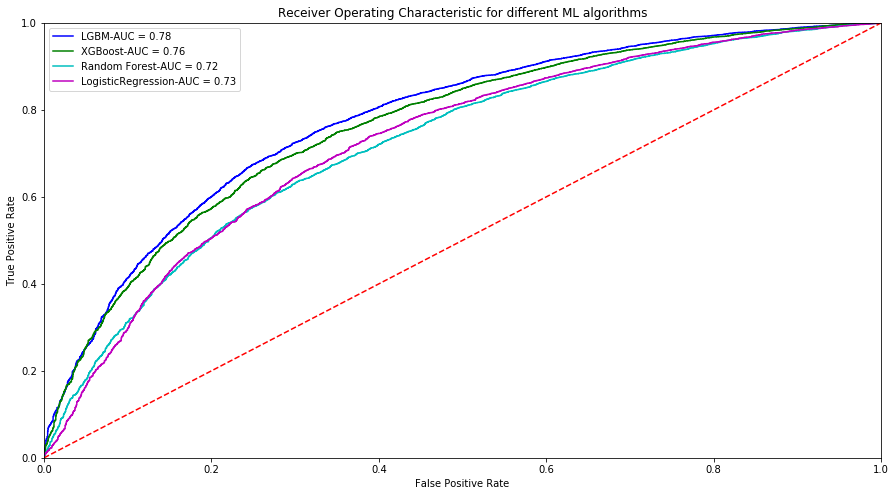

In [162]:
from sklearn.metrics import roc_curve
from sklearn import metrics

fpr,tpr,thresholds=roc_curve(y_valid, valid_preds_lgb)
roc_auc = metrics.auc(fpr, tpr)


fpr_1,tpr_1,thresholds_1=roc_curve(y_valid,xgb_pred_valid)
roc_auc_1 = metrics.auc(fpr_1, tpr_1)


fpr_2,tpr_2,thresholds_1=roc_curve(y_valid,valid_predictions_rf[:,1])
roc_auc_2 = metrics.auc(fpr_2, tpr_2)

fpr_3,tpr_3,thresholds_1=roc_curve(y_valid,valid_predictions_lr[:,1])
roc_auc_3 = metrics.auc(fpr_3, tpr_3)


plt.figure(figsize=(15,8))

plt.title('Receiver Operating Characteristic for different ML algorithms')

plt.plot(fpr, tpr, 'b', label = 'LGBM-AUC = %0.2f' % roc_auc)
plt.plot(fpr_1, tpr_1, 'g', label = 'XGBoost-AUC = %0.2f' % roc_auc_1)
plt.plot(fpr_2, tpr_2, 'c', label = 'Random Forest-AUC = %0.2f' % roc_auc_2)
plt.plot(fpr_3, tpr_3, 'm', label = 'LogisticRegression-AUC = %0.2f' % roc_auc_3)

plt.legend(loc = 'upper left')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()

#### 8.2 Precision Recall curve
Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.

The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels. A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. An ideal system with high precision and high recall will return many results, with all results labeled correctly.

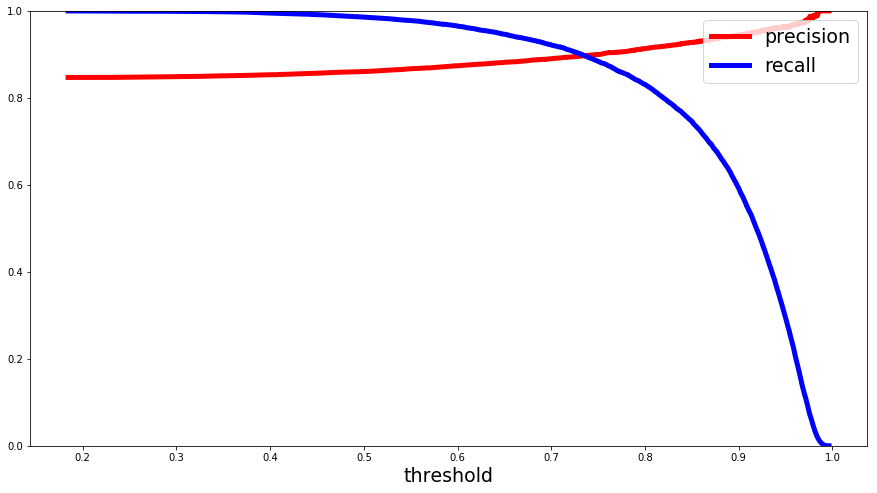

In [163]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_valid, valid_preds_lgb)

def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(15, 8))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

#### 8.3 Feature Importances by Light GBM

Plot metrics during training...


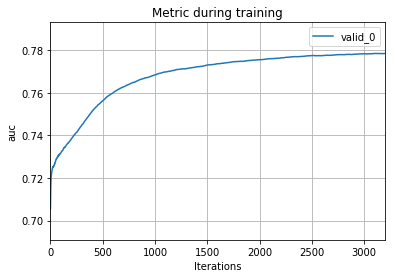

In [165]:
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='auc')
plt.figure(figsize=(15, 8))
plt.show()

#### 8.4 Feature Importances by Light GBM


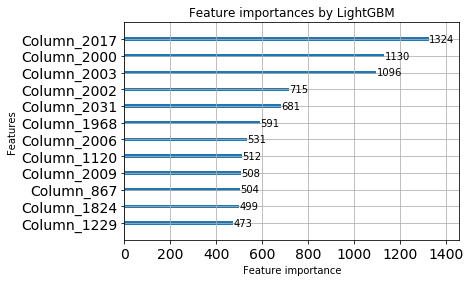

In [166]:
lgb.plot_importance(model_lgb, max_num_features=12)
plt.title("Feature importances by LightGBM")
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()